
# Cassava Leaf Disease Detection


## Using Neural Networks to Identify Diseased Plants

### Lynn Anderson


# Overview

The objective of this project was to build a neural network classification model to identify diseased cassava plants. Cassava roots are an important source of calories and nutrition for many people, especially in sub-Saharan Africa. As the human population increases, it is increasingly important to prioritize crop health, as fertile land is finite and precious. Identifying diseased plants and appropriately treating them in a timely manner is important to ensure adequate yields.  

In this project, models were trained on labelled images. Initially, multiclass classification models were investigated, with the aim of the model being able to classify the plant as healthy or belongng to one of four disease types. However, model performance was very unreliable, and so a binary classification systems was used to identify a plant as either healthy or diseased. A basic neural network was the baseline model, with models consisting of different numbers of hidden layers, and different regularization techniques examined. CNN models and Pre-trained networks were then trained and evaluated, since the basic neural network models were all unsatisfactory. Precision, recall, and F-1 score of the test data  were taken into consideration when evaluating model performance.

# Business Understanding

An agricultural company specializing in treating plant diseases is seeking to implement a model to identify diseased Cassava plants. It is important they can accurately identify plants in need of treatment and determine the best solutions for their customers. However, it is time consuming for the team of plant experts to manually go through images from farmers, and would be much more time efficient to automate the process of identifying diseased cassava plants. 


# Data 

The data for this project was sourced  from the Kaggle Cassava Disease dataset- https://www.kaggle.com/c/cassava-disease/overview. 

The data consisted of leaf images for the cassava plant belonging to one of 5 classes- healthy or four disease
conditions- Cassava Mosaic Disease (CMD), Cassava Bacterial Blight (CBB), Cassava Greem Mite (CGM), and Cassava Brown Streak Disease (CBSD). There were a total of 5,656 labelled images in the dataset. The number of images per class were heavily unbalanced, with two disease classes- CMD and CBSD- representing 72% of the images, and healthy plants only made up 5% of the dataset.

Due to challenges with very poor performance, long run times, and resource usage when training models with the full dataset, a smaller dataset consisting of 1,200 images (300 from each class) was initially used, with the most performant models then investigated on the full dataset. Images were split into training and test sets to validate model performance. 


# Data Preparation

To prepare the data for modeling, the raw data files first needed to be unzipped. Then, they were augumented, preprocessed, and (for basic NN models) reshaped as needed for neural network modeling. Lastly, a dataset for binary classification was develpoed.

*install the following libraries*

In [1]:
# uncomment and run to install

#pip install tensorflow-datasets
#pip install tensorflow
#pip install scikeras
#pip install keras
#pip install lime

In [2]:
# imports
import pandas as pd
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import regularizers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import PIL.Image as Image
from keras.applications import ResNet50V2 
import lime
from keras.applications.imagenet_utils import decode_predictions
from lime import lime_image
from skimage.segmentation import mark_boundaries
import warnings
warnings.simplefilter("ignore")

%matplotlib inline


### Function to visualize model performance

This function plots the accuracy of both training and validation data across the number of epochs.

In [3]:
def visualize_training_results(results):
    
    history = results.history
    
    plt.figure(figsize=(5, 3))
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


### preview files

After downloading the file, all data is found in a single zipped file.

In [4]:
os.listdir('./data')

['cassava-disease.zip',
 'extraimages.zip',
 'random.txt',
 'sample_submission_file.csv',
 'short',
 'test',
 'test.zip',
 'train',
 'train.zip']

##  ***run to unzip files***

run the following cells to unzip the files 

#### unzip the Cassava Disease file

In [5]:
from zipfile import ZipFile
  
# loading the temp.zip and creating a zip object
with ZipFile("data/cassava-disease.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(
        path='./data')

#### unzip test folder

In [6]:
with ZipFile("data/test.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(
        path='./data')

#### unzip train folder

In [7]:
with ZipFile("data/train.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(
        path='./data')

#### preview files

In [8]:
print(os.listdir("./data"))

['cassava-disease.zip', 'extraimages.zip', 'random.txt', 'sample_submission_file.csv', 'short', 'test', 'test.zip', 'train', 'train.zip']


## ***Resume here if files are unzipped***

### preview train folder

In [9]:
print(os.listdir("./data/train"))
print(np.shape(os.listdir("./data/train")))

['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']
(5,)


There are 5 files in the train folder, one for each class.

In [10]:
# preview image names and counts
for sub in os.listdir("./data/short"):
    print(os.listdir("./data/short/" + sub)[:5])
    print(np.shape(os.listdir("./data/short/" + sub)))

['train-cbb-0.jpg', 'train-cbb-1.jpg', 'train-cbb-10.jpg', 'train-cbb-100.jpg', 'train-cbb-101.jpg']
(300,)
['train-cbsd-0.jpg', 'train-cbsd-1.jpg', 'train-cbsd-10.jpg', 'train-cbsd-100.jpg', 'train-cbsd-101.jpg']
(300,)
['train-cgm-0.jpg', 'train-cgm-1.jpg', 'train-cgm-10.jpg', 'train-cgm-100.jpg', 'train-cgm-101.jpg']
(300,)
['train-cmd-0.jpg', 'train-cmd-1.jpg', 'train-cmd-10.jpg', 'train-cmd-100.jpg', 'train-cmd-101.jpg']
(300,)
['train-healthy-0.jpg', 'train-healthy-1.jpg', 'train-healthy-10.jpg', 'train-healthy-100.jpg', 'train-healthy-101.jpg']
(300,)


Each subdirectory contains its respective class of images in a jpg format.

In [11]:
# preview structure of test folder
print(os.listdir("./data/test"))
print(np.shape(os.listdir("./data/test")))

['0']
(1,)


The data in the test directory is not labelled and was used for a competion. I will not be using it in this project, and instead conduct train-test splits in order to validate model performance.

### Preprocess images

In [12]:
# augments and preprocesses images 

train_data_dir = 'data/short'

# Get all the data in the directory data/short and reshape 
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(128, 128), batch_size=1500)

# Create the datasets
train_images, y_train = next(train_generator)


Found 1500 images belonging to 5 classes.


#### preview image labels

In [13]:
y_train

array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]], dtype=float32)

The labels are already in a format suited for modeling.

In [14]:
# preview shape
print(np.shape(train_images))
print(np.shape(y_train))

(1500, 128, 128, 3)
(1500, 5)


### reshape images

The images must be reshaped into a tensor before being input into a neural network model.

In [15]:
train_img_unrow = train_images.reshape(1500, -1)

# Preview the shape of train_img_unrow
print(np.shape(train_img_unrow))

(1500, 49152)


#### normalize pixel values

In [16]:
train_img_unrow /= 255.

# Binary labeling

Label the data as belonging to one of 2 classes, healthy or diseased. First, a dataframe was made from the dataset for easier manipulation.

In [17]:
# make dataframe and preview
df = pd.DataFrame(y_train)
df.head()

,0,1,2,3,4
0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0


In [18]:
# add column for diseased and healthy
df.loc[df[4]==1,"Healthy"]=1
df.loc[df[4]==0,"Healthy"]=0
df.loc[df[4]==1,"Diseased"]=0
df.loc[df[4]==0,"Diseased"]=1
df.head()

,0,1,2,3,4,Healthy,Diseased
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [19]:
#drop other columns and preview
df.drop([0, 1, 2, 3, 4], axis=1, inplace=True)
df.head()

,Healthy,Diseased
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,0.0,1.0
4,0.0,1.0


In [20]:
# check for any null entries
df.isnull().sum()

Healthy     0
Diseased    0
dtype: int64

In [21]:
df['Healthy'].sum()


300.0

In [22]:
df['Diseased'].sum()


1200.0

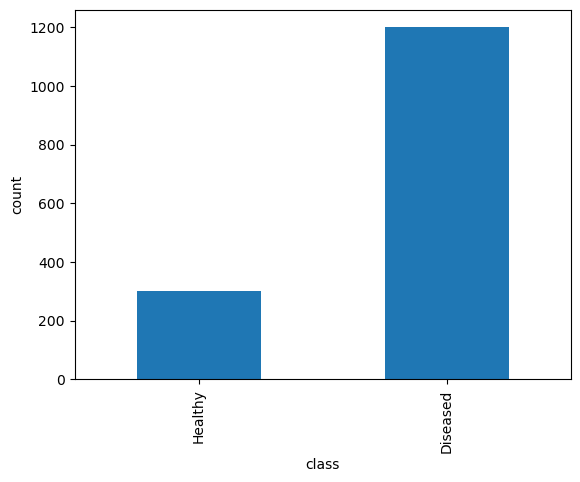

In [23]:
#visualize class imbalance
df.sum().plot(kind='bar', xlabel='class', ylabel='count');

In this analysis, diseased plants outnumber healthy ones 4 to 1.

# Modeling

Initially, multiclass classification models were investigated, with the aim of accurately classifying plants as either healthy or identifying the specific disease. Due to unsatisfactory model performance, a binary classification system was then used to classify plants as either healthy or diseased. 10 different models for each classification system were looked at in total, with a summary of the models and scores below. For the full analysis with with every model, see 
[this notebook](https://github.com/lalynjay/cassava_classification/blob/main/all_models.ipynb)  

Rather than attempt to identify the specific disease using a neural network model, an important first step is to figure out if an image depict a plant that is healthy or diseased. Then, an expert, or perhaps more robust model, could accurately diagnose the specific disease condition. For this situation, minimizing false negatives is important, since a plant predicted as healthy when it is actually diseased would be detrimental to the customer, as their diseased plants going untreated would be the worst case. Thus, recall and F-1 score were most considered when evaluating model performance.

### Multiclass models summary

| Model                  | Precision | Recall | F-1 Score |   |
|------------------------|-----------|--------|-----------|---|
| Basic Neural Network   | .26       | .25    | .16       |   |
| 2 hidden layers        | .29       | .30    | .28       |   |
| 3 hidden layers        | .03       | .20    | .06       |   |
| Grid Search            | .33       | .26    | .23       |   |
| L2 Regularization      | .35       | .35    | .29       |   |
| L1 Regularization      | .04       | .20    | .06       |   |
| Dropout Regularization | .04       | .20    | .06       |   |
| CNN Model              | .29       | .69    | .39       |   |
| ResNet50V2 Model       | .31       | .86    | .45       |   |
| Full ResNet50V2        | .40       | .05    | .09       |   |
|                        |           |        |           |   |

### Binary models summary

| Model                  | Precision | Recall | F-1 Score |   |
|------------------------|-----------|--------|-----------|---|
| Basic Neural Network   | .41       | .50    | .45       |   |
| 2 hidden layers        | .38       | .50    | .43       |   |
| 3 hidden layers        | .41       | .50    | .45       |   |
| Grid Search            | .67       | .58    | .58       |   |
| L2 Regularization      | .61       | .62    | .61       |   |
| L1 Regularization      | .42       | .50    | .46       |   |
| Dropout Regularization | .42       | .50    | .46       |   |
| CNN Model              | .69       | .58    | .58       |   |
| ResNet50V2 Model       | .84       | .76    | .78       |   |
| Full ResNet50V2        | .62       | .55    | .57       |   |
|                        |           |        |           |   |



## Multiclass Classification Models

Among the multiclass classification models looked at, the CNN and pretrained ResNet models were the only models that demonstrated some competence- all others had F-1 scores below 0.3, and even the best model- the pretrained ResNet- had an F-1 score of .46. Thus, all models failed to satisfactorily classify the plants.

Thw first two models in this notebook will demonstrate the multiclass classification model training and evaluation.


### Multiclass Convoluted Neural Network (CNN) model 

CNN models are known to perform well on image recognition tasks. Rather than just looking at individual pixels,they learn local patterns by grouping adjacent pixels.Thus, when a convolutional neural network recognizes a pattern in one region, these insights can be shared and applied to other regions. Additionally, deeper CNNs can learn spatial hierarchies- for example, a first layer will learn small local patterns, a second layer will learn larger patterns using features of the first layer patterns, etc.

As expected, the CNN outperformed the other basic multiclass neural network models. However, with F-1 scores no higher than 0.41, it was still not satisfactory.

#### train-test split for CNN modeling

In [24]:
cnn_train, cnn_test, cnn_train_labels, cnn_test_labels= train_test_split(train_images, 
                                                                         y_train, 
                                                                         test_size=0.2, 
                                                                         random_state=42,
                                                                         shuffle=True)

In [25]:
# instantiate and train model
np.random.seed(42)
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128, 128, 3))) 
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(5, activation='sigmoid'))

cnn_model.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])
cnn_results = cnn_model.fit(cnn_train,
                            cnn_train_labels, 
                            epochs=10,
                            batch_size=16,
                            validation_data=(cnn_test, cnn_test_labels))




Epoch 1/10


75/75 [==============================] - 11s 126ms/step - loss: 1.6119 - acc: 0.1892 - val_loss: 1.5993 - val_acc: 0.2600
Epoch 2/10
75/75 [==============================] - 9s 115ms/step - loss: 1.6038 - acc: 0.2375 - val_loss: 1.5931 - val_acc: 0.2100
Epoch 3/10
75/75 [==============================] - 8s 112ms/step - loss: 1.5944 - acc: 0.2658 - val_loss: 1.6018 - val_acc: 0.1800
Epoch 4/10
75/75 [==============================] - 9s 118ms/step - loss: 1.5859 - acc: 0.2725 - val_loss: 1.5743 - val_acc: 0.2233
Epoch 5/10
75/75 [==============================] - 9s 122ms/step - loss: 1.5682 - acc: 0.2933 - val_loss: 1.5890 - val_acc: 0.2067
Epoch 6/10
75/75 [==============================] - 9s 122ms/step - loss: 1.5497 - acc: 0.3067 - val_loss: 1.5326 - val_acc: 0.3067
Epoch 7/10
75/75 [==============================] - 9s 119ms/step - loss: 1.5251 - acc: 0.3242 - val_loss: 1.4978 - val_acc: 0.3367
Epoch 8/10
75/75 [==============================] - 9s 122ms/step - lo

### Evaluation

In [40]:
y_pred = cnn_model.predict(cnn_test)

10/10 [==============================] - 1s 52ms/step


In [41]:
print(classification_report(cnn_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.38      0.38      0.38        66
           1       0.33      0.53      0.41        60
           2       0.25      0.88      0.39        60
           3       0.27      0.86      0.41        58
           4       0.22      0.80      0.35        56

   micro avg       0.27      0.68      0.39       300
   macro avg       0.29      0.69      0.39       300
weighted avg       0.30      0.68      0.39       300
 samples avg       0.28      0.68      0.39       300



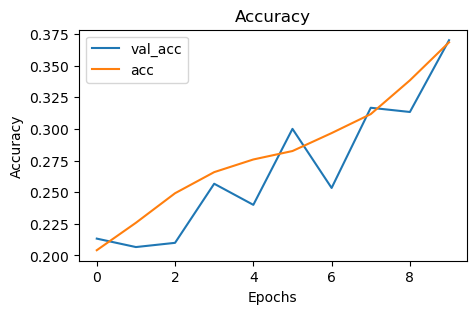

In [42]:
visualize_training_results(cnn_results)

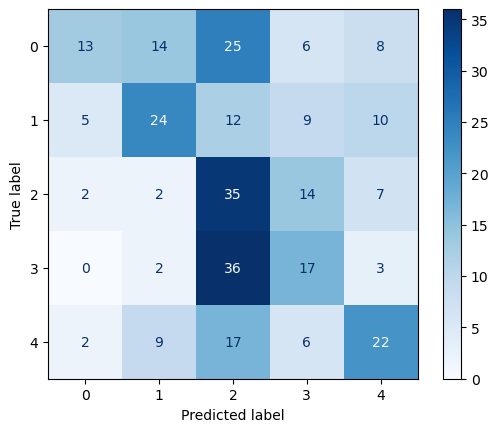

In [43]:
#confusion_matrix(y_test.values.argmax(axis=1), predictions.argmax(axis=1))

cnf_matrix = confusion_matrix(cnn_test_labels.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)#, display_labels=all_cnn_test_labels)
disp.plot(cmap=plt.cm.Blues);

The model was rather unreliable, as many predictions were incorrect. 

### Pretrained Multiclass ResNet Model

Pre-trained models are pre-built machine learning models that have already been trained on large datasets. These datasets often contain millions of images, which allows the models to learn a wide range of features and patterns. Moreover, training a machine learning model from scratch can be a time-consuming process and by using pre-trained models, lots of time and resources can be saved by starting with a model that has already been trained.

ResNet models were developed specifically for image classification. ResNet-50 is a pretrained Convolutional Neural Network(CNN) model that is 50 layers deep and trained on a million images of 1000 categories from the ImageNet database. 

Given the complexity of Resnet models compared to the previous ones, it was no surprise it performed better than any other multiclassification model. However, predictions were still quite inaccurate and this model would not be of much use.

#### Instantiate and train Resnet model

In [25]:
# instantiate resnet
resnet = ResNet50V2(weights='imagenet', 
                 include_top=False, 
                 input_shape=(128, 128, 3))

In [45]:
#instantiate and train model 
np.random.seed(42)
res_model = models.Sequential()
res_model.add(resnet)
res_model.add(layers.Flatten())
res_model.add(layers.Dense(132, activation='relu'))
res_model.add(layers.Dense(5, activation='sigmoid'))


In [46]:
# preview trainable layers
for layer in res_model.layers:
    print(layer.name, layer.trainable)
    
# check how many trainable weights are in the model
print(len(res_model.trainable_weights))

resnet50v2 True
flatten_3 True
dense_6 True
dense_7 True
176


In [47]:
# freeze resnet layer
resnet.trainable = False

In [48]:
# verify resnet50v2 is set to False
for layer in res_model.layers:
    print(layer.name, layer.trainable)
    
# check how many trainable weights are in the model
print(len(res_model.trainable_weights))

resnet50v2 False
flatten_3 True
dense_6 True
dense_7 True
4


In [49]:
# compile and train the model

res_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

res_history = res_model.fit(cnn_train,
                    cnn_train_labels,
                    steps_per_epoch=27,
                    epochs=10,
                    validation_data=(cnn_test, cnn_test_labels),
                    validation_steps=10)

Epoch 1/10
27/27 [==============================] - 38s 1s/step - loss: 1.7654 - acc: 0.3350 - val_loss: 1.5362 - val_acc: 0.3900
Epoch 2/10
27/27 [==============================] - 34s 1s/step - loss: 1.1086 - acc: 0.5592 - val_loss: 1.4577 - val_acc: 0.4567
Epoch 3/10
27/27 [==============================] - 32s 1s/step - loss: 0.8290 - acc: 0.6900 - val_loss: 1.4704 - val_acc: 0.4500
Epoch 4/10
27/27 [==============================] - 32s 1s/step - loss: 0.6254 - acc: 0.7992 - val_loss: 1.4292 - val_acc: 0.4567
Epoch 5/10
27/27 [==============================] - 34s 1s/step - loss: 0.4777 - acc: 0.8717 - val_loss: 1.4437 - val_acc: 0.4667
Epoch 6/10
27/27 [==============================] - 33s 1s/step - loss: 0.3672 - acc: 0.9325 - val_loss: 1.4644 - val_acc: 0.4533
Epoch 7/10
27/27 [==============================] - 33s 1s/step - loss: 0.2804 - acc: 0.9617 - val_loss: 1.4507 - val_acc: 0.4733
Epoch 8/10
27/27 [==============================] - 32s 1s/step - loss: 0.2121 - acc: 0.98

### Evaluation

In [50]:
y_pred = res_model.predict(cnn_test)

10/10 [==============================] - 8s 685ms/step


In [51]:
print(classification_report(cnn_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.33      0.86      0.48        66
           1       0.27      0.88      0.41        60
           2       0.26      0.87      0.40        60
           3       0.32      0.86      0.47        58
           4       0.35      0.82      0.49        56

   micro avg       0.30      0.86      0.45       300
   macro avg       0.31      0.86      0.45       300
weighted avg       0.31      0.86      0.45       300
 samples avg       0.34      0.86      0.47       300



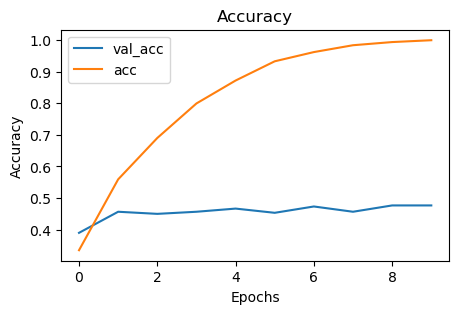

In [53]:
visualize_training_results(res_history)

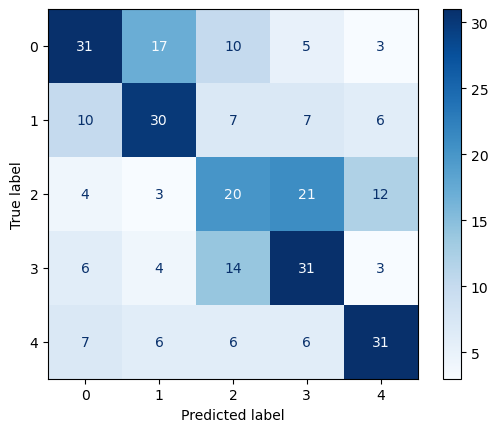

In [54]:
#confusion_matrix(y_test.values.argmax(axis=1), predictions.argmax(axis=1))

cnf_matrix = confusion_matrix(cnn_test_labels.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)#, display_labels=all_cnn_test_labels)
disp.plot(cmap=plt.cm.Blues);

This model was the best yet and had fairly high recall scores, but the precision and F-1 are still rather low. This means there are many false positives (yet few false negatives) in the predictions, meaning an image predicted belonging to a certain class cannot be trusted. 

## Binary classification Modeling

While it is ideal to be able to identify specific diseases, simply detecting disease is an important first step. This next section seeked to classify images into one of two categories- healthy or diseased. Again, baseline neural network models were investigated, followed by a CNN and Resnet model. Images of diseased plants consisted of 80% of the dataset, so it was still quite imbalanced. In many of the models, it appeared to indiscriminately classify plants as diseased. However, the pretrained model far outperformed all others. 

### Basic neural network with 2 hidden layers

#### Train-test split for binary classification networks

In [30]:
binary_train, binary_test, binary_train_labels, binary_test_labels= train_test_split(train_img_unrow, df, 
                                                                                     test_size=0.2, 
                                                                                     random_state=42,
                                                                                     shuffle=True)

In [69]:
np.random.seed(123)
binary_model_2 = models.Sequential()
binary_model_2.add(layers.Dense(256, activation='relu', input_shape=(49152,))) 
binary_model_2.add(layers.Dense(32, activation='relu'))
binary_model_2.add(layers.Dense(2, activation='sigmoid'))
binary_model_2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

binary_results_2 = binary_model_2.fit(binary_train, 
                        binary_train_labels,
                        epochs=10,
                        batch_size=16,
                        validation_data=(binary_test, binary_test_labels))

Epoch 1/10
75/75 [==============================] - 5s 60ms/step - loss: 0.5179 - acc: 0.8058 - val_loss: 0.5694 - val_acc: 0.7667
Epoch 2/10
75/75 [==============================] - 5s 61ms/step - loss: 0.4880 - acc: 0.8083 - val_loss: 0.5926 - val_acc: 0.7667
Epoch 3/10
75/75 [==============================] - 4s 54ms/step - loss: 0.4835 - acc: 0.8083 - val_loss: 0.5658 - val_acc: 0.7667
Epoch 4/10
75/75 [==============================] - 4s 55ms/step - loss: 0.4638 - acc: 0.8083 - val_loss: 0.5212 - val_acc: 0.7667
Epoch 5/10
75/75 [==============================] - 4s 55ms/step - loss: 0.4542 - acc: 0.8083 - val_loss: 0.5445 - val_acc: 0.7667
Epoch 6/10
75/75 [==============================] - 4s 54ms/step - loss: 0.4493 - acc: 0.8083 - val_loss: 0.5260 - val_acc: 0.7667
Epoch 7/10
75/75 [==============================] - 4s 54ms/step - loss: 0.4396 - acc: 0.8083 - val_loss: 0.5189 - val_acc: 0.7667
Epoch 8/10
75/75 [==============================] - 4s 53ms/step - loss: 0.4347 - a

### Evaluation

In [70]:
y_pred = binary_model_2.predict(binary_test)

10/10 [==============================] - 0s 15ms/step


In [71]:
print(classification_report(binary_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        70
           1       0.77      1.00      0.87       230

   micro avg       0.77      0.77      0.77       300
   macro avg       0.38      0.50      0.43       300
weighted avg       0.59      0.77      0.67       300
 samples avg       0.77      0.77      0.77       300



This model failed to correctly identify any healthy plants- appearing to predict most as diseased. 

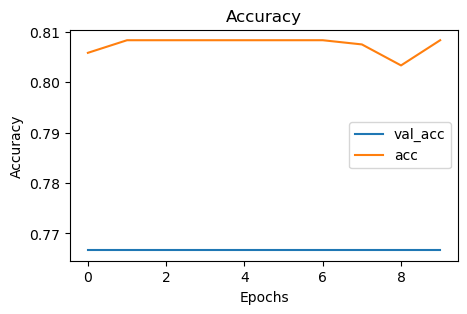

In [72]:
visualize_training_results(binary_results_2)

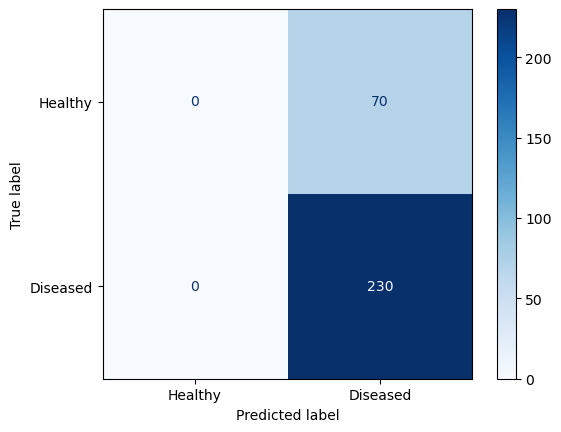

In [77]:
#confusion_matrix

cnf_matrix = confusion_matrix(binary_test_labels.values.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=binary_test_labels)
disp.plot(cmap=plt.cm.Blues);

The model simply predicted every image as belonging to a diseased plant, thus was useless.

###  CNN Binary Classification Model

This one performed much better than the basic neural network models, but still was unreliable in identifying healthy plants.

#### train-test split

In [29]:
cnn_binary_train, cnn_binary_test, cnn_binary_train_labels, cnn_binary_test_labels= train_test_split(train_images,
                                                                                                     df, 
                                                                                                     test_size=0.2, 
                                                                                                     random_state=42,
                                                                                                     shuffle=True)

In [58]:
np.random.seed(42)
binary_cnn_model = models.Sequential()
binary_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128, 128, 3))) 
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Flatten())
binary_cnn_model.add(layers.Dense(64, activation='relu'))
binary_cnn_model.add(layers.Dense(2, activation='softmax'))

binary_cnn_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])
binary_cnn_results = binary_cnn_model.fit(cnn_binary_train,
                            cnn_binary_train_labels,
                            epochs=10,
                            batch_size=16,
                            validation_data=(cnn_binary_test, cnn_binary_test_labels))


Epoch 1/10
75/75 [==============================] - 11s 133ms/step - loss: 0.4953 - acc: 0.8033 - val_loss: 0.5314 - val_acc: 0.7667
Epoch 2/10
75/75 [==============================] - 9s 120ms/step - loss: 0.4765 - acc: 0.8083 - val_loss: 0.5157 - val_acc: 0.7667
Epoch 3/10
75/75 [==============================] - 10s 132ms/step - loss: 0.4607 - acc: 0.8083 - val_loss: 0.5392 - val_acc: 0.7667
Epoch 4/10
75/75 [==============================] - 9s 122ms/step - loss: 0.4417 - acc: 0.8092 - val_loss: 0.4844 - val_acc: 0.7667
Epoch 5/10
75/75 [==============================] - 9s 123ms/step - loss: 0.4259 - acc: 0.8083 - val_loss: 0.4884 - val_acc: 0.7667
Epoch 6/10
75/75 [==============================] - 9s 122ms/step - loss: 0.4102 - acc: 0.8058 - val_loss: 0.4980 - val_acc: 0.7667
Epoch 7/10
75/75 [==============================] - 9s 122ms/step - loss: 0.3992 - acc: 0.8125 - val_loss: 0.5933 - val_acc: 0.7667
Epoch 8/10
75/75 [==============================] - 10s 132ms/step - loss

### Evaluation

In [62]:
y_pred = binary_cnn_model.predict(cnn_binary_test)

10/10 [==============================] - 1s 62ms/step


In [63]:
print(classification_report(cnn_binary_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.58      0.20      0.30        70
           1       0.80      0.96      0.87       230

   micro avg       0.78      0.78      0.78       300
   macro avg       0.69      0.58      0.58       300
weighted avg       0.75      0.78      0.74       300
 samples avg       0.78      0.78      0.78       300



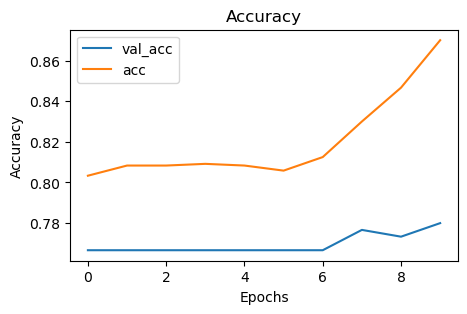

In [61]:
visualize_training_results(binary_cnn_results)

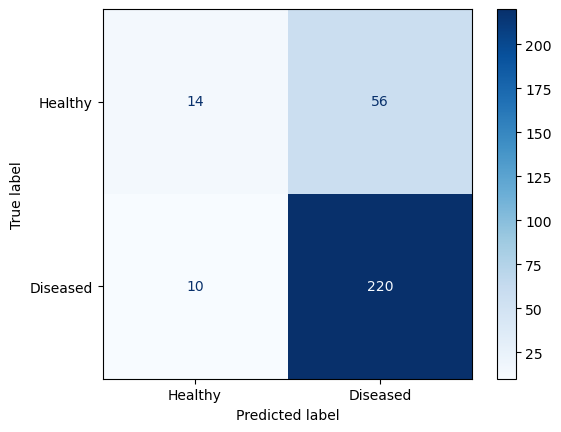

In [64]:
#confusion_matrix

cnf_matrix = confusion_matrix(cnn_binary_test_labels.values.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=cnn_binary_test_labels)
disp.plot(cmap=plt.cm.Blues);

Clearly an improvement from the basic model, but this one still fails to accurately classify healthy plants. 

### Pretrained ResNet Model

This model far outperformed any others. Out of a total of 228 diseased plants, it incorrectly labelled 4 as healthy. However, it also predicted many plants that were actually healthy to be diseased. 

In [26]:
#instantiate and train model  
np.random.seed(42)
binary_res_model = models.Sequential()
binary_res_model.add(resnet)
binary_res_model.add(layers.Flatten())
binary_res_model.add(layers.Dense(132, activation='relu'))
binary_res_model.add(layers.Dense(2, activation='sigmoid'))

In [27]:
# freeze resnet layer and verify
resnet.trainable = False

for layer in binary_res_model.layers:
    print(layer.name, layer.trainable)
    

print(len(binary_res_model.trainable_weights))

resnet50v2 False
flatten True
dense True
dense_1 True
4


In [30]:
# train model
binary_res_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

#np.random.seed(42) 

binary_res_history = binary_res_model.fit(cnn_binary_train,
                    cnn_binary_train_labels,
                    steps_per_epoch=27,
                    epochs=10,
                    validation_data=(cnn_binary_test, cnn_binary_test_labels),                   
                    validation_steps=10)

Epoch 1/10


27/27 [==============================] - 38s 1s/step - loss: 0.5174 - acc: 0.7858 - val_loss: 0.4194 - val_acc: 0.8333
Epoch 2/10
27/27 [==============================] - 32s 1s/step - loss: 0.3308 - acc: 0.8600 - val_loss: 0.3880 - val_acc: 0.8400
Epoch 3/10
27/27 [==============================] - 33s 1s/step - loss: 0.2496 - acc: 0.9117 - val_loss: 0.3628 - val_acc: 0.8467
Epoch 4/10
27/27 [==============================] - 33s 1s/step - loss: 0.1980 - acc: 0.9350 - val_loss: 0.3782 - val_acc: 0.8300
Epoch 5/10
27/27 [==============================] - 33s 1s/step - loss: 0.1574 - acc: 0.9533 - val_loss: 0.3650 - val_acc: 0.8500
Epoch 6/10
27/27 [==============================] - 34s 1s/step - loss: 0.1270 - acc: 0.9675 - val_loss: 0.3592 - val_acc: 0.8467
Epoch 7/10
27/27 [==============================] - 41s 2s/step - loss: 0.1033 - acc: 0.9733 - val_loss: 0.3697 - val_acc: 0.8533
Epoch 8/10
27/27 [==============================] - 35s 1s/step - loss: 0.0844 - acc: 0.

### Evaluation

In [31]:
y_pred = binary_res_model.predict(cnn_binary_test)

10/10 [==============================] - 8s 632ms/step


In [32]:
print(classification_report(cnn_binary_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.59      0.36      0.44        56
           1       0.89      0.94      0.91       244

   micro avg       0.85      0.83      0.84       300
   macro avg       0.74      0.65      0.68       300
weighted avg       0.83      0.83      0.83       300
 samples avg       0.82      0.83      0.83       300



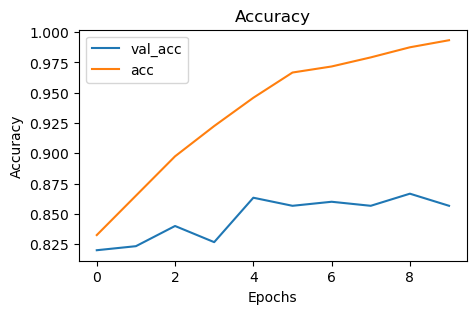

In [34]:
visualize_training_results(binary_res_history)

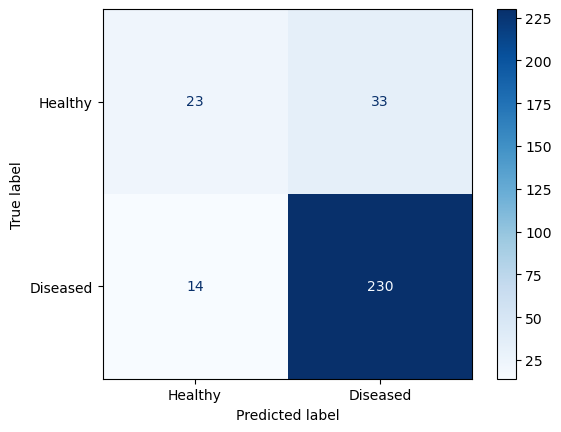

In [33]:
#confusion_matrix

cnf_matrix = confusion_matrix(cnn_binary_test_labels.values.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=cnn_binary_test_labels)
disp.plot(cmap=plt.cm.Blues);

While there is certainly room for improvement, this model is by far the best yet. It still struggles with correctly identifying healthy plants, but there are relatively few false negatives, which is important in this scenario.

## Resnet model on full dataset

The binary classification Resnet model was then trained and evaluated on the entire dataset. Initially, the Resnet model trained on the small dataset was evaluated on the full dataset, with extremely poor performance. A multiclass model on the entire dataset was trained and evaluated as well, again with sub-par results. The binary classification Resnet model trained and evaluated on the full dataset was far worse overall than the smaller model. 

#### data preparation

In [26]:
full_data_dir = 'data/train'

# Get all the data in the directory data/train and reshape them
full_train_generator = ImageDataGenerator().flow_from_directory(
        full_data_dir, 
        target_size=(128, 128), batch_size=5656)

# Create the datasets
all_train_images, all_y_train = next(full_train_generator)


Found 5656 images belonging to 5 classes.


#### preview image labels

In [27]:
# preview shape
print(np.shape(all_train_images))
print(np.shape(all_y_train))

(5656, 128, 128, 3)
(5656, 5)


#### Binary labeling


In [28]:
# make dataframe and preview
all_df = pd.DataFrame(all_y_train)
all_df.loc[all_df[4]==1,"Healthy"]=1
all_df.loc[all_df[4]==0,"Healthy"]=0
all_df.loc[all_df[4]==1,"Diseased"]=0
all_df.loc[all_df[4]==0,"Diseased"]=1
all_df.drop([0, 1, 2, 3, 4], axis=1, inplace=True)
all_df.head()

,Healthy,Diseased
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


In [29]:
# check for any null entries
all_df.isnull().sum()

Healthy     0
Diseased    0
dtype: int64

In [31]:
print("healthy: ", all_df['Healthy'].sum())
print("diseased: ", all_df['Diseased'].sum())

print("Percent of images belonging to healthy plants: ", round(all_df['Healthy'].sum() / all_df['Diseased'].sum() * 100, 2), "%")

healthy:  316.0
diseased:  5340.0
Percent of images belonging to healthy plants:  5.92 %


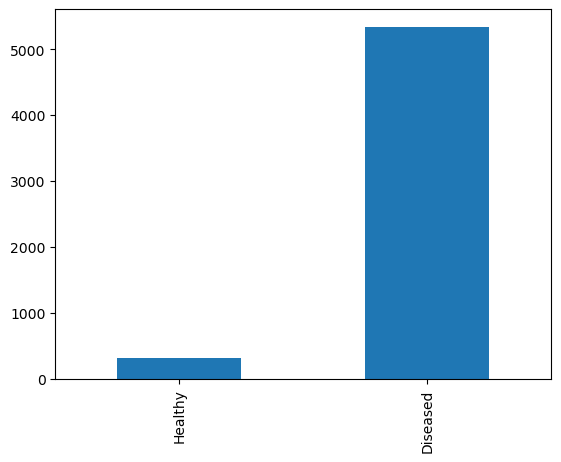

In [84]:
all_df.sum().plot(kind='bar');

#### train-test split

In [85]:
all_cnn_binary_train, all_cnn_binary_test, all_cnn_binary_train_labels, all_cnn_binary_test_labels= train_test_split(all_train_images,
                                                                                                                     all_df, test_size=0.2, 
                                                                                                                     random_state=42,
                                                                                                                     shuffle=True)


### Resnet binary classification model- full dataset


In [12]:
#instantiate and train model  
resnet = ResNet50V2(weights='imagenet', 
                 include_top=False, 
                 input_shape=(128, 128, 3))
all_binary_res_model = models.Sequential()
all_binary_res_model.add(resnet)
all_binary_res_model.add(layers.Flatten())
all_binary_res_model.add(layers.Dense(132, activation='relu'))
all_binary_res_model.add(layers.Dense(2, activation='sigmoid'))

In [13]:
resnet.trainable = False

In [14]:
for layer in all_binary_res_model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model
print(len(all_binary_res_model.trainable_weights))

resnet50v2 False
flatten True
dense True
dense_1 True
4


In [15]:
np.random.seed(42)

all_binary_res_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])
all_binary_res_history = all_binary_res_model.fit(all_cnn_binary_train,
                    all_cnn_binary_train_labels,
                    steps_per_epoch=27,
                    epochs=10,
                    validation_data=(all_cnn_binary_test, all_cnn_binary_test_labels),                   
                    validation_steps=10)

Epoch 1/10


27/27 [==============================] - 238s 8s/step - loss: 8.1307 - acc: 0.9047 - val_loss: 5.0235 - val_acc: 0.9417
Epoch 2/10
27/27 [==============================] - 227s 8s/step - loss: 4.8344 - acc: 0.9304 - val_loss: 4.2549 - val_acc: 0.9417
Epoch 3/10
27/27 [==============================] - 222s 8s/step - loss: 4.4966 - acc: 0.9224 - val_loss: 3.0947 - val_acc: 0.9302
Epoch 4/10
27/27 [==============================] - 235s 9s/step - loss: 3.7092 - acc: 0.9332 - val_loss: 4.2473 - val_acc: 0.9417
Epoch 5/10
27/27 [==============================] - 226s 8s/step - loss: 3.3666 - acc: 0.9330 - val_loss: 4.0339 - val_acc: 0.9417
Epoch 6/10
27/27 [==============================] - 229s 9s/step - loss: 2.8326 - acc: 0.9344 - val_loss: 2.3271 - val_acc: 0.8843
Epoch 7/10
27/27 [==============================] - 228s 9s/step - loss: 2.8290 - acc: 0.9381 - val_loss: 3.0782 - val_acc: 0.8295
Epoch 8/10
27/27 [==============================] - 228s 9s/step - loss: 2.5911 -

### Evaluation

In [16]:
y_pred = all_binary_res_model.predict(all_cnn_binary_test)

36/36 [==============================] - 55s 1s/step


In [17]:
print(classification_report(all_cnn_binary_test_labels, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.30      0.12      0.17        66
           1       0.95      0.99      0.97      1066

   micro avg       0.93      0.94      0.93      1132
   macro avg       0.62      0.55      0.57      1132
weighted avg       0.91      0.94      0.92      1132
 samples avg       0.93      0.94      0.93      1132



C:\Users\lalyn\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


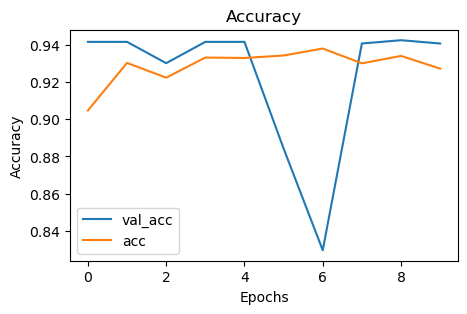

In [18]:
visualize_training_results(all_binary_res_history)

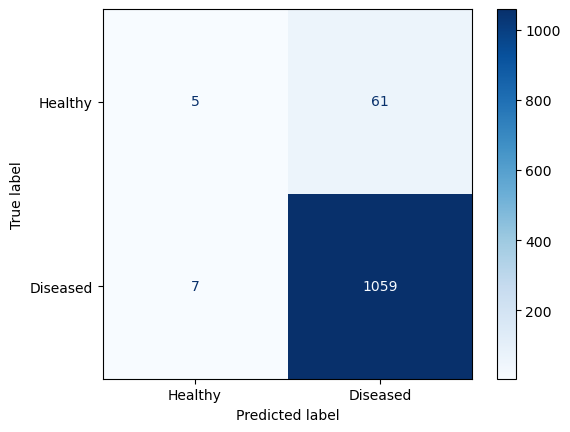

In [19]:
#confusion_matrix(y_test.values.argmax(axis=1), predictions.argmax(axis=1))

cnf_matrix = confusion_matrix(all_cnn_binary_test_labels.values.argmax(axis=1), y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=all_cnn_binary_test_labels)
disp.plot(cmap=plt.cm.Blues);

This model performs significantly worse than the same one trained with the smaller dataset. Of 66 healthy plants, only 5 were correctly identified, and only 5 of 12 predicted to be healthy actually were.

# Visualization with LIME

The LIME library is used to reveal which pixels of an image were most important in the model's prediction. It should be expected that the model would be paying most attention to the leaves of the plant and not the parts of the image that are not vegetation. It appears this is mostly the case, with the model paying most attention to the leaf ends and center of the plant. The binary classification ResNet model's predictions were used in this section, given that it was by far the most accurate model.

In [36]:
from keras.applications.imagenet_utils import decode_predictions
from lime import lime_image
from skimage.segmentation import mark_boundaries
preds = binary_res_model.predict(train_images)

47/47 [==============================] - 63s 1s/step


In [57]:
# %%time
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(train_images[2].astype('double'), binary_res_model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 659ms/step


### display image

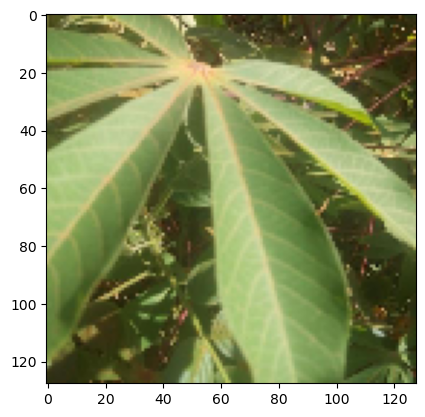

In [60]:
plt.imshow(train_images[2].astype('double'))
plt.show()

#### see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

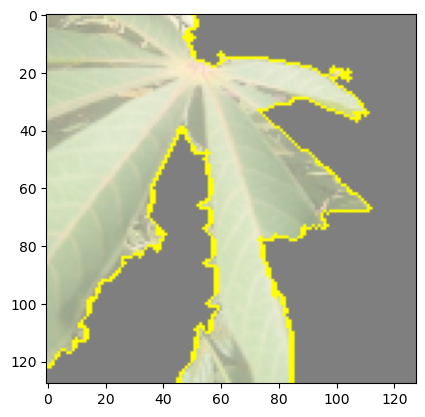

In [59]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype('double'));

#### Or with the rest of the image present:

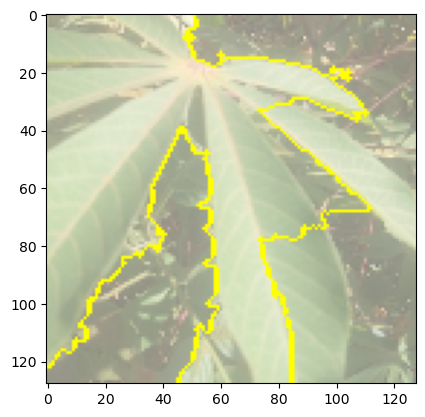

In [61]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype('double'));

For this image, the model was focusing its attention on the center of the plant as well as the two leaves in the center of the image. It also appears to be placing some importance on pixels that do not belong to the plant, which likely contributes to incorrect predictions.

#### see the 'pros and cons' (pros in green, cons in red)

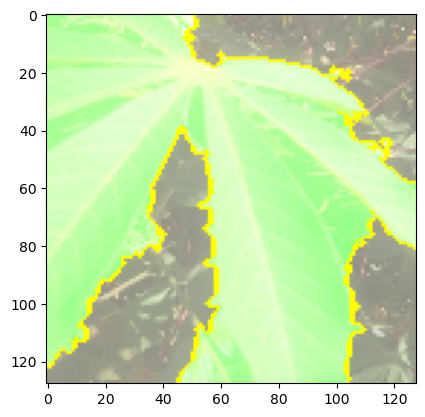

In [45]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask).astype('double'));

#### plot explanation weights onto a heatmap visualization. The colorbar shows the values of the weights.

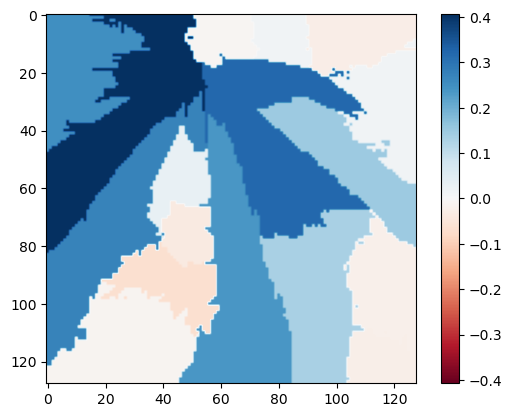

In [46]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar();

Again we see that the center and central two leaves were most important in the models predictions. 

# Visualization of correct and incorrect predictions

In order to gain insight on where the model may be going right and wrong, it is helpful to take a look at some images that were both corrctly and incorrectly predicted. This next section demonstrates a sample of such images and their predicted and actual class. An inspection of some images incorrectly predicted as healthy show that those may not demonstrate quite as much yellowing as the correctly identified diseased plants. 

In [34]:
correct = np.nonzero(cnn_binary_test_labels.values.argmax(axis=1) == y_pred.argmax(axis=1))[0]
incorrect = np.nonzero(cnn_binary_test_labels.values.argmax(axis=1) != y_pred.argmax(axis=1))[0]

In [41]:
correct

array([  0,   1,   2,   4,   5,   6,   8,   9,  10,  11,  12,  13,  14,
        15,  18,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  31,
        35,  38,  39,  40,  41,  42,  43,  44,  45,  47,  48,  51,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  68,
        69,  70,  72,  73,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 122, 123, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169,
       170, 171, 173, 174, 175, 176, 177, 178, 179, 181, 182, 183, 184,
       185, 186, 187, 189, 190, 191, 192, 193, 194, 195, 196, 199, 200,
       201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 212, 21

### Correct predictions

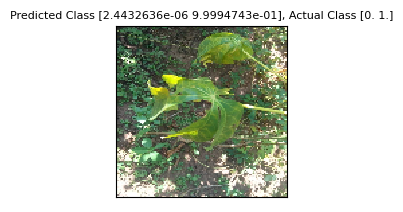

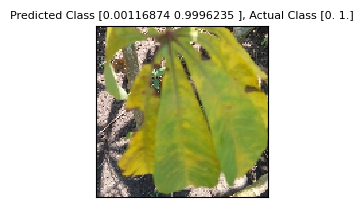

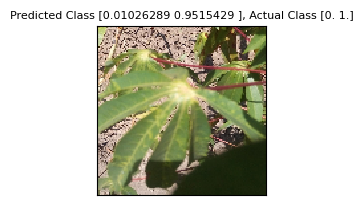

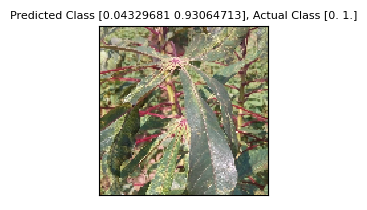

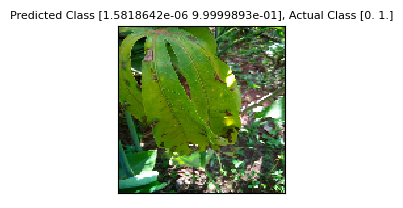

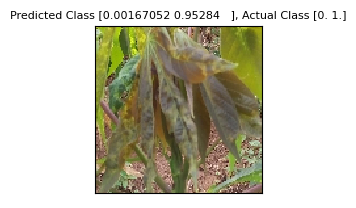

In [44]:
# Use a for loop to iterate through correct predictions,
# display the prediction values for each image and the actual class of the model
i = 0
for c in correct[:6]:
    figsize = [10, 6]
    fig, ax = plt.subplots(figsize=figsize, facecolor=(1, 1, 1))
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(cnn_binary_test[c], interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(y_pred[c], cnn_binary_test_labels.values[c]), fontsize=8)
    plt.tight_layout()
    i += 1

All images in this sample were correctly identified as diseased. There is some degree of yellowing and/or lighter colored splotches in every image shown.

### Incorrect predictions

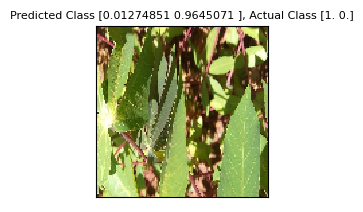

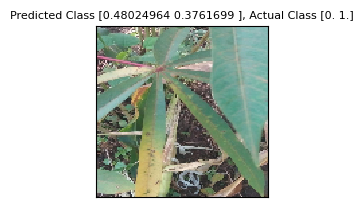

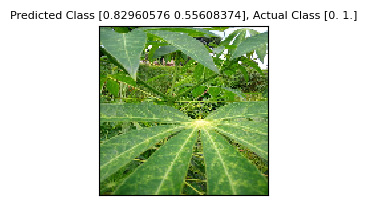

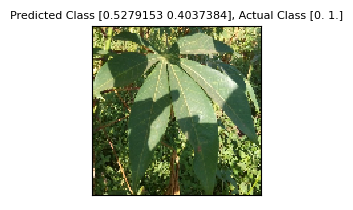

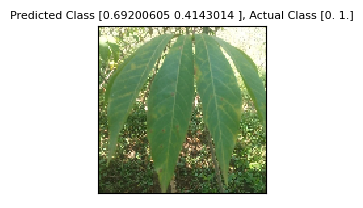

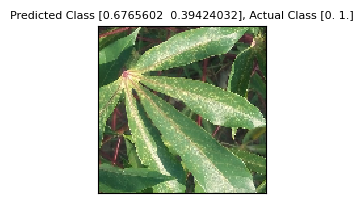

In [114]:
# Use a for loop to iterate through incorrect predictions,
# display the prediction values for each image and the actual class of the model
i = 0
for c in incorrect[:6]:
    figsize = [10, 6]
    fig, ax = plt.subplots(figsize=figsize, facecolor=(1, 1, 1))
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(cnn_binary_test[c], interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(y_pred[c], cnn_binary_test_labels.values[c]), fontsize=8)
    plt.tight_layout()
    i += 1

The first image was incorrectly predicted as diseased, all others shown were incorrectly predicted as healthy. When compared to the images correctly predicted as diseased, it is evident these images display less obvious yellowing and/or different lighting/background. The first image also has a different perspective, showing a few leaves but not the center of the plant. This suggests the need for consistency among images.  

# Visualizing Activation layers

This section demonstrates how to display the activations of different layers of the binary classification CNN network. By examining the activations, it can be determoned which features the network learns by comparing areas of activation with the original image. [this notebook](https://github.com/lalynjay/cassava_classification/blob/main/activation_layers.ipynb)

## view every channel of the first activation layer

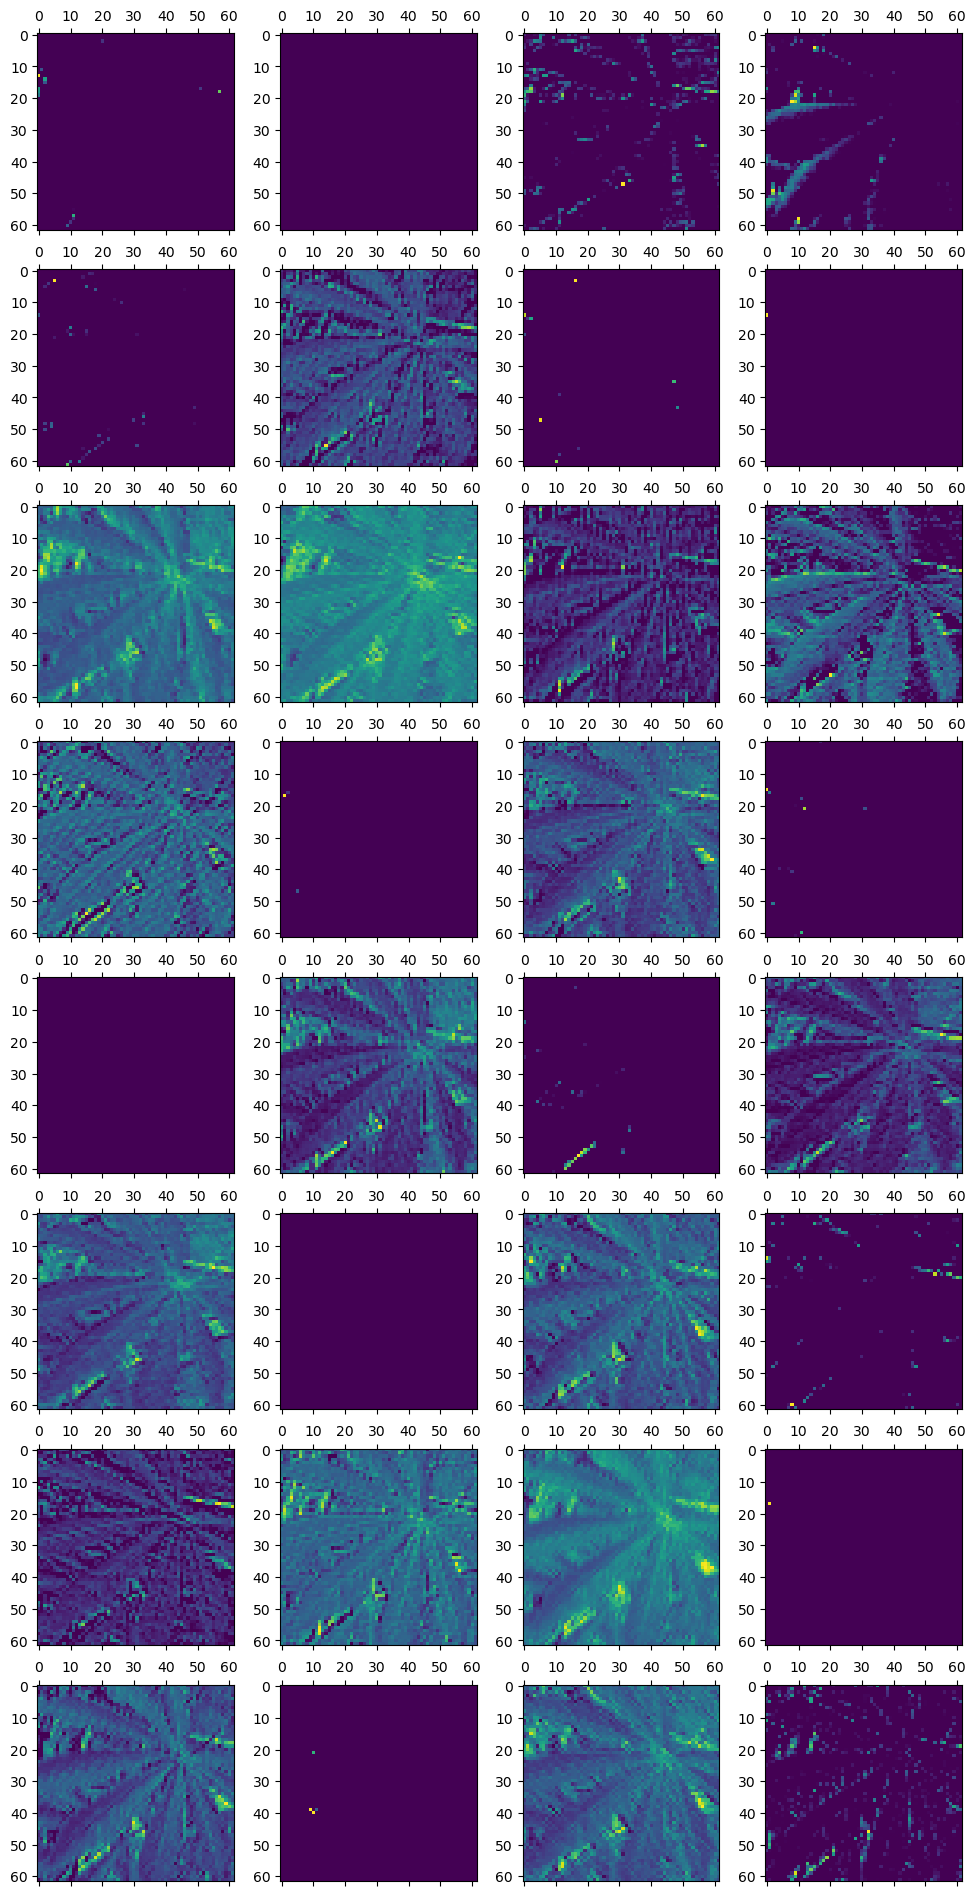

In [22]:
layer_outputs = [layer.output for layer in binary_cnn_model.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=binary_cnn_model.input, outputs=layer_outputs)


fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

For this model it appears that many of the layers were paying attention to the center of the plant and the soil/litter below the plant. 

# Recommendations


   * Start with the smaller Resnet model, but have an expert verify
   
   
   * Instruct the farmer on how to collect images- lighting, parts of plant, etc 
   

   * Focus on center of plant and large leaves
   
    
   

# Conclusions


   * Simple neural network models were inadequate for accurately classifying the Cassava images
   

   * The pretrained Resnet model was far better than any others in correctly classifying images
   
    
   * A model trained and evaluated on the full dataset had much room for improvement, likely due to challanges with the extreme         dataset imbalance.
   
  

# Next Steps and Limitations 


   * The image size for modeling was 128 x 128 pixels. Attempts at larger image sizes resulted in errors and crashes. Recreate the modeling process using a more powerful machine that can handle a much larger dataset size. 
   
   
   * Create a more detailed standard for imaging for both training and predictions
   
    
   * Gather more images of the underrepresented classes
   
    
   * Further investigate other pre-trained models

# For More Information

See the full analysis in the [Jupyter Notebook](https://github.com/lalynjay/cassava_classification/blob/main/Time_series_analysis.ipynb) or review [this presentation](https://github.com/lalynjay/cassava_classification/blob/main/ts_presentation.pdf)

For additional info, contact Lynn Anderson at lalynjay@gmail.com

Repository Structure

├── data 

├── images

├── README.md

├── cassava_presentation.pdf

└── final_notebook.ipynb

└── all_models.ipynb

└── activation_layers.ipynb



# References

[Interpreting Image Classification Model with LIME](https://towardsdatascience.com/interpreting-image-classification-model-with-lime-1e7064a2f2e5)

[The Annotated ResNet-50](https://towardsdatascience.com/the-annotated-resnet-50-a6c536034758)